In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, wishart
from scipy.special import digamma
import data, random

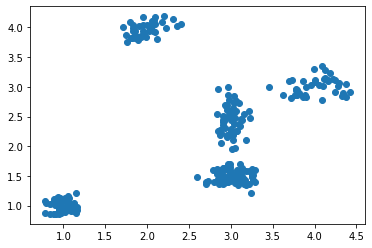

In [2]:
centers_x = [1, 2,   3,   3, 4]
centers_y = [1, 4, 1.5, 2.5, 3]
covs = [np.array([[1, 0],[0, 1]]), 
        np.array([[2, 0.3],[0.3, 1]]),
        np.array([[2, -0.3],[-0.3, 1]]),
        np.array([[1, 0.3],[0.3, 6]]), 
        np.array([[5, 0.1],[0.1, 2]])]
datanums = [60, 40, 80, 60, 40]

K = 10

data = []

for i in range(5):
    p = multivariate_normal((centers_x[i], centers_y[i]), covs[i]/100)
    data.extend(p.rvs(datanums[i]))
    
#random.shuffle(data)
data.sort(key = lambda x: x[0])
#print(data)

plt.scatter([x for (x,y) in data], [y for (x,y) in data])


In [3]:

def initial_r(data):
    rs = []
    for i,d in enumerate(data):
        r = [0]*K
        p = int(i/len(data)*K)
        r[p] = 1.0
        
        rs.append(r)
        
    return rs

In [4]:
rs = initial_r(data)

In [5]:
def weighted_num(k, rs):
    return sum([r[k] for r in rs])

def weighted_mean(k, rs, data):
    return sum([ r[k]*p for (r, p) in zip(rs, data)])/weighted_num(k, rs)
    
def weighted_cov(k, rs, data):
    xbar = weighted_mean(k, rs, data)
    return sum([ r[k]*(p-xbar).reshape((2, 1)).dot((p-xbar).reshape((2, 1)).T) for (r, p) in zip(rs, data)])/weighted_num(k, rs)

In [6]:
def update_params(org_alpha, org_beta, org_nu, org_m, org_w_inv, k, ns, xs, covs):
    alpha = org_alpha + ns[k]
    beta = org_beta + ns[k]
    nu = org_nu + ns[k]
    m = (org_beta * org_m + ns[k]*xs[k])/beta
    w_inv = org_w_inv + ns[k]*covs[k] + (org_beta*ns[k])/(org_beta + ns[k])*(xs[k] - org_m).reshape((2,1)).dot((xs[k] - org_m).reshape((2,1)).T)
    
    return (alpha, beta, nu, m, w_inv)

In [7]:
def rho(d, k, alphas, betas, nus, ms, w_invs):
    first = digamma(alphas[k]) - digamma(sum(alphas))
    second_2 = digamma((nus[k])/2) + digamma((nus[k] - 1)/2) + np.log(1/np.linalg.det(w_invs[k]))
    third_2 = 2/betas[k] + nus[k]*(d - ms[k]).reshape((2,1)).T.dot(np.linalg.inv(w_invs[k])).dot((d - ms[k]).reshape((2,1)))[0][0]
    
    log_rho = first + second_2/2 - third_2/2
    
    return np.exp(log_rho)

In [8]:
def calc_rs(alphas, betas, nus, ms, w_invs):
    rs = []
    for d in data:
        rhos = [ rho(d, k, alphas, betas, nus, ms, w_invs) for k in range(K)]
        sm = sum(rhos)
        rs.append(rhos/sm)
        
    return rs

In [9]:
def graph(data, ms, betas, w_invs, ns):
    plt.scatter([x for (x,y) in data], [y for (x,y) in data])
    plt.scatter([x for (x,y) in ms], [y for (x,y) in ms], color="red")
    sigmas = [ w_invs[k]/betas[k]/2 for k in range(K)]
    
    normals = [multivariate_normal(mean=ms[k], cov=sigmas[k]) for k in range(K) ]
    
    x, y = np.mgrid[0:5:100j, 0:4:100j]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x 
    pos[:, :, 1] = y 

    for k,n in enumerate(normals):
        if ns[k] > 1:
            plt.contour(x, y, n.pdf(pos), levels=3) 
    

In [10]:
alphas = [1]*K
betas = [1]*K
nus = [1]*K
ms = [np.array([0,0])]*K
w_invs = [np.array([[1, 0],[0, 1]])]*K

In [11]:

def one_step(rs):
    ns = [weighted_num(k, rs) for k in range(K)]
    xs = [weighted_mean(k, rs, data) for k in range(K)]
    covs = [weighted_cov(k, rs, data) for k in range(K)]

    print(ns)
    for k in range(K):
        if ns[k] < 0.01:
         #   ms[k] = np.array([0,0])
            continue
            
        params = update_params(1,1,1, np.mean(data), np.array([[1, 0],[0, 1]]), k, ns, xs, covs)
        alphas[k] = params[0]
        betas[k] = params[1]
        nus[k] = params[2]
        ms[k] = params[3]
        w_invs[k] = params[4]

    
    graph(data, ms, betas, w_invs, ns)
    return calc_rs(alphas, betas, nus, ms, w_invs)
    
#    print(alphas)
#    print(betas)
#    print(nus)

#    print(w_invs)
#    print(ms) 
#    print(rs)

[28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0]


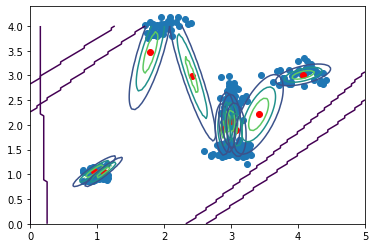

In [12]:
rs = one_step(rs)

In [13]:
print(ms)

[array([0.95713796, 1.06257946]), array([1.09597894, 1.0465951 ]), array([1.7949951, 3.4671578]), array([2.4187266 , 2.98707024]), array([2.87594562, 1.91002988]), array([2.94544037, 2.05125076]), array([3.00170399, 2.08042151]), array([3.07707432, 1.90257048]), array([3.41116494, 2.21249671]), array([4.07570897, 3.01174553])]


[28.85307122823074, 30.802155307307785, 28.070995251565563, 16.573492354370384, 25.7394827002435, 30.93023279256977, 32.978170127756684, 33.880446410872295, 16.68384546996908, 35.488108357114186]
[28.48715902388332, 31.512840315167917, 33.58612889739017, 7.726784784344833, 25.18524987954409, 32.655484648156644, 35.52474065410427, 36.6468046857178, 9.440843478398271, 39.233963633292724]
[27.744746740496293, 32.255234885481215, 37.325837738709154, 2.975695171535755, 24.811416817168382, 33.82073472630856, 37.406081852134044, 37.95911972500434, 4.8322775067580945, 40.86885483640409]
[26.815245077125915, 33.1847536275014, 39.269445735734834, 0.7727189738414822, 24.61902243712959, 34.451704569211984, 38.99498318517237, 38.29029769232755, 2.1351080301802243, 41.466720671774624]
[25.78585544268054, 34.214144555912604, 39.96278269640402, 0.03930257342861551, 26.008690716647376, 34.323256148190055, 40.10700985449784, 37.366135685207986, 0.5572220574629712, 41.63560026956803]
[24.75770992368061, 

[2.4905291219509988e-14, 60.0, 40.0000005673269, 2.066676078941785e-18, 80.01009017147864, 4.788454467008864e-12, 59.42939009075749, 4.615178831495364e-06, 1.9863678173209774e-38, 40.56051455525328]
[2.4905291219509922e-14, 60.0, 40.0000005673269, 2.066676078941785e-18, 80.01009017147864, 4.788454467008926e-12, 59.42939009075756, 4.615178831495442e-06, 1.9863678173210252e-38, 40.56051455525321]
[2.4905291219509673e-14, 60.0, 40.0000005673269, 2.066676078941785e-18, 80.01009017147864, 4.7884544670088965e-12, 59.429390090757586, 4.615178831495432e-06, 1.986367817321013e-38, 40.56051455525318]
[2.490529121950972e-14, 60.0, 40.0000005673269, 2.066676078941785e-18, 80.01009017147864, 4.788454467008913e-12, 59.4293900907576, 4.615178831495448e-06, 1.9863678173210223e-38, 40.56051455525318]
[2.4905291219509758e-14, 60.0, 40.0000005673269, 2.066676078941785e-18, 80.01009017147864, 4.788454467008922e-12, 59.4293900907576, 4.615178831495455e-06, 1.9863678173210294e-38, 40.56051455525317]
[2.4905

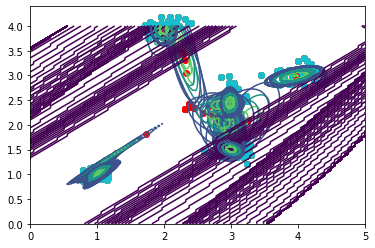

In [14]:
for _ in range(20):
    rs = one_step(rs)

[2.4905291219509704e-14, 60.0, 40.0000005673269, 2.066676078941785e-18, 80.01009017147864, 4.788454467008922e-12, 59.4293900907576, 4.615178831495466e-06, 1.9863678173210328e-38, 40.560514555253164]


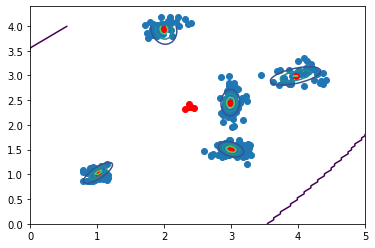

In [15]:
rs = one_step(rs)